## File: daily_tasks_analysis.ipynb
#### Summary: This file focuses on analysing occupations with frequent daily tasks as a test.

#### By: Peyman Shahidi
#### First Created: May 29, 2024

#### Last Edit by Peyman on May 29, 2024

In [1]:
#Python
import os
import getpass
import glob
import numpy as np
import pandas as pd
import random
from itertools import product
from datetime import datetime
epoch = datetime.utcfromtimestamp(0)
from datetime import timedelta
import math as math
import unicodedata
import json
import requests
import gzip
import shutil
import re
from urllib.request import urlopen

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [2]:
# determine user
user = getpass.getuser()
if user == 'peymansh':
    main_folder_path = '/Users/peymansh/Dropbox (MIT)/Research/AI and Occupations/ai-exposure'
    data_path = f'{main_folder_path}/output/data'
    output_path = f'{main_folder_path}/output/daily_tasks_occupations_analysis'

### Functions

In [3]:
def fix_names(name):
    name = name.replace(" ", "_")
    remote = [" ", "\\$", "/", "%", "-", "\\(", "\\)", "\\*"]
    for i in remote:
        name = re.sub(i, "", name)
    name = re.sub("__", "_", name)
    name = name.lower()
    return name


def GPT_prompter(system_role_msg, prompt, temperature, api_key):
    # send request to GPT
    response = requests.post(
        url = "https://api.openai.com/v1/chat/completions",
        headers = {"Authorization": f"Bearer {api_key}"},
        json ={
            "model": "gpt-4o",
            "temperature": temperature,
            "seed": 265,
            "messages": [{"role": "system", "content": system_role_msg},
                         {"role": "user", "content": prompt}
                        ]
        }
    )
    
    # GPT's answer
    answer = response.json()['choices'][0]['message']['content']
    return answer


def extract_numeric(text):
    pattern = r'{answer:\s*([0-9]+\.?[0-9]*)\s*(?:minutes)?}'
    match = re.search(pattern, text)
    return float(match.group(1)) if match else None

### Main Code Starts Here

In [4]:
# Read O*NET data
onet = pd.read_csv(f'{data_path}/onet_occupations_yearly.csv')
onet = onet.sort_values(by=['year', 'occ_code', 'occ_title', 'task_id'])

# some filters
# keep 2023 only
onet = onet[onet['year'] == 2023].reset_index(drop=True)

# Drop if missing information
onet = onet.dropna(subset=['yearly_or_less'])

In [5]:
# get number of unique tasks in each occupation
onet['num_tasks'] = onet.groupby(['year', 'occ_code', 'occ_title'])['task_id'].transform('nunique')

In [6]:
# sort occupations on number of unique tasks performed
unique_tasks = onet[['year', 'occ_code', 'occ_title', 
                     'num_tasks']].drop_duplicates(subset=['year', 'occ_code', 'occ_title'])
unique_tasks = unique_tasks.sort_values(by=['year', 'num_tasks']).reset_index(drop=True)

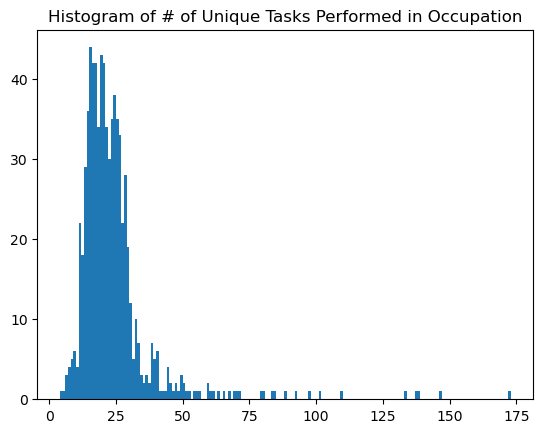

In [7]:
# plot histogram of occupations based on number of unique tasks
bin_width = 1
plot_data = unique_tasks['num_tasks']
bins = np.arange(min(plot_data), max(plot_data) + bin_width, bin_width)
plt.hist(plot_data, bins=bins)
plt.title('Histogram of # of Unique Tasks Performed in Occupation')
plt.show()

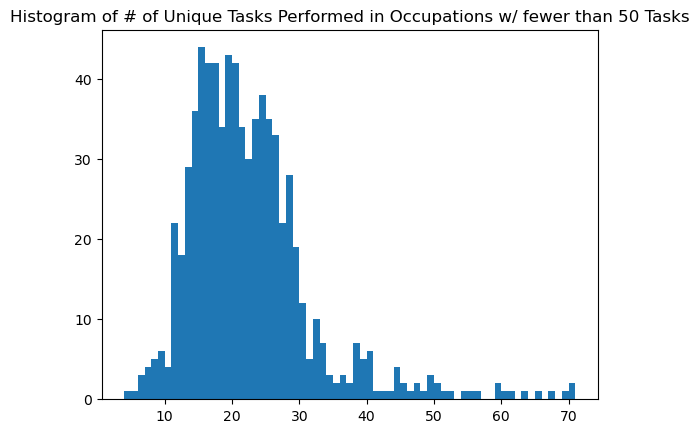

In [8]:
# plot histogram of occupations based on number of unique tasks
bin_width = 1
plot_data = unique_tasks[unique_tasks.num_tasks<75]['num_tasks']
bins = np.arange(min(plot_data), max(plot_data) + bin_width, bin_width)
plt.hist(plot_data, bins=bins)
plt.title('Histogram of # of Unique Tasks Performed in Occupations w/ fewer than 50 Tasks')
plt.show()

In [9]:
# sanity check: baristas
unique_tasks[unique_tasks.occ_code == '35-3011']

,year,occ_code,occ_title,num_tasks
352,2023,35-3011,Bartenders,20


In [10]:
# get list of occupations with <10 number of unique tasks performed
max_num_tasks = 10
selected_occupations = unique_tasks[unique_tasks.num_tasks < max_num_tasks]
selected_occupations = selected_occupations['occ_code'].tolist()


print(f'occupations w/ less than {max_num_tasks} tasks (core + supplemental)')
print_df = onet[onet.occ_code.isin(selected_occupations)][['year', 'occ_code', 'occ_title', 'num_tasks']]
print_df = print_df.drop_duplicates()
print_df.sort_values(by=['num_tasks', 'occ_code'])

occupations w/ less than 10 tasks (core + supplemental)


,year,occ_code,occ_title,num_tasks
15032,2023,39-5093,Shampooers,4
17748,2023,47-2072,Pile Driver Operators,5
17165,2023,45-2041,"Graders and Sorters, Agricultural Products",6
23267,2023,53-1041,Aircraft Cargo Handling Supervisors,6
24154,2023,53-7031,Dredge Operators,6
1832,2023,13-1032,"Insurance Appraisers, Auto Damage",7
2714,2023,13-2053,Insurance Underwriters,7
17541,2023,47-2043,Floor Sanders and Finishers,7
18081,2023,47-2171,Reinforcing Iron and Rebar Workers,7
283,2023,11-3011,Administrative Services Managers,8


In [11]:
# subset occupations w/ a few number of tasks from O*NET data
aux_df = onet[onet.occ_code.isin(selected_occupations)].sort_values(by=['year', 'num_tasks', 'occ_code', 'task_id'])

# check what fraction of task is performed frequently within occupation
aux_df['daily_and_more_frequent_tasks_share'] = aux_df.apply(lambda row: row.daily + row.several_times_daily + row.hourly_or_more, axis=1)


# define frequent core task as those which:
# 1) are core tasks
# 2) are performed (daily - several_times_daily - hourly_or_more) in more than 70% of times
frequent_task_threshold = 60
aux_df['frequent_core_task'] = aux_df.apply(lambda row: 1 if (row.task_type == 'Core') & (row.daily_and_more_frequent_tasks_share > frequent_task_threshold) 
                                                     else 0, axis=1)

In [12]:
# if occupation is comprised of mostly frequent core tasks it is a "quick" occupation
quick_occ_df = aux_df.groupby(['year', 'occ_code', 'occ_title', 'num_tasks'])['frequent_core_task'].mean().reset_index()
quick_occ_df = quick_occ_df.sort_values(by=['num_tasks', 'frequent_core_task']).reset_index(drop=True)
quick_occ_df = quick_occ_df.rename(columns={'frequent_core_task': 'share_frequent_core_tasks'})

# define "quick" as occupations with share of frequent core task >75%
share_frqnt_core_task_threshold = 0.75
quick_occ_list = quick_occ_df[quick_occ_df.share_frequent_core_tasks >= share_frqnt_core_task_threshold]['occ_code'].tolist()


print(f'"quick" occupations defined as those w/ share of frequent core tasks >{share_frqnt_core_task_threshold*100}%')
quick_occ_df[quick_occ_df.share_frequent_core_tasks >= share_frqnt_core_task_threshold]

"quick" occupations defined as those w/ share of frequent core tasks >75.0%


,year,occ_code,occ_title,num_tasks,share_frequent_core_tasks
1,2023,47-2072,Pile Driver Operators,5,1.00
4,2023,53-7031,Dredge Operators,6,0.75
7,2023,13-2053,Insurance Underwriters,7,0.75
8,2023,47-2043,Floor Sanders and Finishers,7,0.75
12,2023,33-9031,Gambling Surveillance Officers and Gambling In...,8,0.87
13,2023,41-3041,Travel Agents,8,0.88


#### Now that I have occupations of interest do the analysis

In [13]:
# Read O*NET data
onet = pd.read_csv(f'{data_path}/onet_occupations_yearly.csv')
onet = onet.sort_values(by=['year', 'occ_code', 'occ_title', 'task_id'])


# subset "Gambling Surveillance Officers and Gambling Investigators" for investigation
# Notes:
# 1) in 2018 has fewer tasks that appear in all later years
# 2) 2019 onwards all tasks are same
# 3) in 2018 and 2019 task 4411 is labeled as Supplemental while later it becomes Core
#onet[onet.occ_code == '33-9031'].to_csv('/Users/peymansh/Downloads/33_9031.csv')

#### Shampooers

In [15]:
# Subset 2023 and Shampooers
df = onet[(onet.occ_code == '39-5093') & (onet.year == 2023)]

# List of tasks and occupation
tasks_list = df['task'].unique()
adjacency_matrix_raw = pd.DataFrame(index=tasks_list, columns=tasks_list)
adjacency_matrix_raw.to_csv(f'{output_path}/shampooers/shampooers_AM_raw.csv', columns=tasks_list, index=True)
occupation = df['occ_title'].iloc[0]

#### Pile Driver Operators

In [73]:
# Subset 2023 and Pile Driver Operators
df = onet[(onet.occ_code == '47-2072') & (onet.year == 2023)]

# List of tasks and occupation
tasks_list = df['task'].unique()
adjacency_matrix_raw = pd.DataFrame(index=tasks_list, columns=tasks_list)
adjacency_matrix_raw.to_csv(f'{output_path}/pileDriverOperators/pileDriverOperators_AM_raw.csv', columns=tasks_list, index=True)
occupation = df['occ_title'].iloc[0]

#### Insurance Underwriters

In [75]:
# Subset 2023 and Insurance Underwriters
df = onet[(onet.occ_code == '13-2053') & (onet.year == 2023)]

# List of tasks and occupation
tasks_list = df['task'].unique()
adjacency_matrix_raw = pd.DataFrame(index=tasks_list, columns=tasks_list)
adjacency_matrix_raw.to_csv(f'{output_path}/insuranceUnderwriters/insuranceUnderwriters_AM_raw.csv', columns=tasks_list, index=True)
occupation = df['occ_title'].iloc[0]

#### Dredge Operators Matrix

In [44]:
# Subset 2023 and Dredge Operators
df = onet[(onet.occ_code == '53-7031') & (onet.year == 2023)]

# List of tasks and occupation
tasks_list = df['task'].unique()
adjacency_matrix_raw = pd.DataFrame(index=tasks_list, columns=tasks_list)
adjacency_matrix_raw.to_csv(f'{output_path}/dredgeOperators/dredgeOperators_AM_raw.csv', columns=tasks_list, index=True)
occupation = df['occ_title'].iloc[0]


# matrices
temp = 0
prompt = f'I am giving you {len(tasks_list)} tasks for this occupation: {occupation}:\n'
i = 1
for task in tasks_list:
    prompt = prompt + f'Task {i}: {str(task)}'
    i += 1
prompt = prompt + f'\n\nI want you to tell me if any combination of two tasks in the above list are immediately related to one another. \
Give the output in markdown table format in form of an adjacency matrix, where rows and columns are the tasks listed above and \
elements of matrix are 1 if the two tasks are related and 0 if the two tasks are not related.'

prompt += f'\n\nMoreover, tell me for all pairs of tasks whether one preceeds, succeeds, or has no relationship with the other. \
Return output in form of a markdown table where, if row task immediately preceeds the column task the entry is 1, if row task immediately succeeds column task the entry is 2, \
and if tasks are unrelated the entry is 0.'


persona = f'You are answering questions as if you were a human. Do not break character. \
You are an agent with the following persona: an expert dredge operator who is at the top of their game.'


ans = GPT_prompter(system_role_msg=persona, 
                       prompt=prompt, 
                       temperature=temp, 
                       api_key=api_key)
ans

"Sure, let's start with the adjacency matrix to determine if any combination of two tasks are immediately related to one another.\n\n### Adjacency Matrix\n\n|       | Task 1 | Task 2 | Task 3 | Task 4 | Task 5 | Task 6 |\n|-------|--------|--------|--------|--------|--------|--------|\n| Task 1| 1      | 1      | 1      | 0      | 1      | 1      |\n| Task 2| 1      | 1      | 1      | 0      | 0      | 0      |\n| Task 3| 1      | 1      | 1      | 0      | 0      | 1      |\n| Task 4| 0      | 0      | 0      | 1      | 0      | 0      |\n| Task 5| 1      | 0      | 0      | 0      | 1      | 0      |\n| Task 6| 1      | 0      | 1      | 0      | 0      | 1      |\n\n### Precedence Matrix\n\n|       | Task 1 | Task 2 | Task 3 | Task 4 | Task 5 | Task 6 |\n|-------|--------|--------|--------|--------|--------|--------|\n| Task 1| 0      | 1      | 1      | 0      | 1      | 1      |\n| Task 2| 2      | 0      | 0      | 0      | 0      | 0      |\n| Task 3| 2      | 0      | 0      |

#### Matrices of Travel Agents

In [43]:
# Subset 2023 and Travel Agents
df = onet[(onet.occ_code == '41-3041') & (onet.year == 2023)]

# List of tasks and occupation
tasks_list = df['task'].unique()
adjacency_matrix_raw = pd.DataFrame(index=tasks_list, columns=tasks_list)
adjacency_matrix_raw.to_csv(f'{output_path}/travelAgents/travelAgents_AM_raw.csv', columns=tasks_list, index=True)
occupation = df['occ_title'].iloc[0]


# matrices
temp = 0
prompt = f'I am giving you {len(tasks_list)} tasks for this occupation: {occupation}:\n'
i = 1
for task in tasks_list:
    prompt = prompt + f'Task {i}: {str(task)}'
    i += 1
prompt = prompt + f'\n\nI want you to tell me if any combination of two tasks in the above list are immediately related to one another. \
Give the output in markdown table format in form of an adjacency matrix, where rows and columns are the tasks listed above and \
elements of matrix are 1 if the two tasks are related and 0 if the two tasks are not related.'

prompt += f'\n\nMoreover, tell me for all pairs of tasks whether one preceeds, succeeds, or has no relationship with the other. \
Return output in form of a markdown table where, if row task immediately preceeds the column task the entry is 1, if row task immediately succeeds column task the entry is 2, \
and if tasks are unrelated the entry is 0.'


persona = f'You are answering questions as if you were a human. Do not break character. \
You are an agent with the following persona: an expert travel agent who is at the top of their game.'


ans = GPT_prompter(system_role_msg=persona, 
                       prompt=prompt, 
                       temperature=temp, 
                       api_key=api_key)
ans

'Certainly! Here are the two tables you requested:\n\n### Adjacency Matrix for Task Relationships\n\n|     | Task 1 | Task 2 | Task 3 | Task 4 | Task 5 | Task 6 | Task 7 | Task 8 |\n|-----|--------|--------|--------|--------|--------|--------|--------|--------|\n| Task 1 | 1      | 1      | 1      | 1      | 1      | 0      | 1      | 1      |\n| Task 2 | 1      | 1      | 1      | 1      | 1      | 1      | 0      | 1      |\n| Task 3 | 1      | 1      | 1      | 1      | 1      | 0      | 1      | 1      |\n| Task 4 | 1      | 1      | 1      | 1      | 1      | 0      | 1      | 1      |\n| Task 5 | 1      | 1      | 1      | 1      | 1      | 1      | 0      | 1      |\n| Task 6 | 0      | 1      | 0      | 0      | 1      | 1      | 0      | 0      |\n| Task 7 | 1      | 0      | 1      | 1      | 0      | 0      | 1      | 1      |\n| Task 8 | 1      | 1      | 1      | 1      | 1      | 0      | 1      | 1      |\n\n### Task Precedence Matrix\n\n|     | Task 1 | Task 2 | Task 3 

#### Restrict attention to "Gambling Surveillance Officers and Gambling Investigators"

In [14]:
# subset "Gambling Surveillance Officers and Gambling Investigators"
df = onet[onet.occ_code == '33-9031']

# Standardize task IDs across time
df['task_id'] = df.sort_values(by=['task', 'year']).groupby('task')['task_id'].transform('last')


# Keep tasks that appear in 2023
# kept from Radiology analysis of Sam
tasks_2023 = df[df['year'] == 2023].groupby('task_id').size().reset_index(name='count')['task_id'].tolist()
df = df[df['task_id'].isin(tasks_2023)]


# Aggregate to task level, carry forward non-missing values
df = df.sort_values(by='year').groupby(['occ_code', 'occ_title', 'task_id', 'task', 'task_type']).agg(
    yearly_or_less=('yearly_or_less', 'last'),
    more_than_yearly=('more_than_yearly', 'last'),
    more_than_monthly=('more_than_monthly', 'last'),
    more_than_weekly=('more_than_weekly', 'last'),
    daily=('daily', 'last'),
    several_times_daily=('several_times_daily', 'last'),
    hourly_or_more=('hourly_or_more', 'last'),
    task_importance=('task_importance', 'last'),
    task_relevance=('task_relevance', 'last')
).reset_index()

df

,occ_code,occ_title,task_id,task,task_type,yearly_or_less,more_than_yearly,more_than_monthly,more_than_weekly,daily,several_times_daily,hourly_or_more,task_importance,task_relevance
0,33-9031,Gambling Surveillance Officers and Gambling In...,4407,Observe casino or casino hotel operations for ...,Core,0.00,0.00,1.60,0.78,15.37,14.35,67.91,4.79,96.87
1,33-9031,Gambling Surveillance Officers and Gambling In...,4408,Report all violations and suspicious behaviors...,Core,0.00,0.00,3.36,5.15,26.33,6.86,58.30,4.79,100.00
2,33-9031,Gambling Surveillance Officers and Gambling In...,4409,Monitor establishment activities to ensure adh...,Core,0.00,0.00,1.55,0.66,17.15,8.06,72.58,4.80,98.83
3,33-9031,Gambling Surveillance Officers and Gambling In...,4410,Act as oversight or security agents for manage...,Core,0.00,3.62,1.79,2.07,18.49,16.80,57.22,4.44,84.96
4,33-9031,Gambling Surveillance Officers and Gambling In...,4411,Supervise or train surveillance observers.,Core,8.11,22.53,9.12,20.94,25.71,1.98,11.61,4.08,84.66
5,33-9031,Gambling Surveillance Officers and Gambling In...,4411,Supervise or train surveillance observers.,Supplemental,9.09,16.49,24.72,6.57,15.96,4.27,22.88,4.04,57.66
6,33-9031,Gambling Surveillance Officers and Gambling In...,21145,Develop and maintain log of surveillance obser...,Core,0.00,0.00,2.72,0.00,10.74,3.85,82.69,4.71,99.21
7,33-9031,Gambling Surveillance Officers and Gambling In...,21146,Inspect and monitor audio or video surveillanc...,Core,0.00,1.22,0.34,1.01,37.56,9.46,50.41,4.65,96.19
8,33-9031,Gambling Surveillance Officers and Gambling In...,21147,Review video surveillance footage.,Core,0.00,1.20,3.95,0.23,21.03,25.67,47.92,4.60,98.04


In [15]:
# Fork out importance/relevance
weights = df.groupby(['task_id', 'task_importance', 'task_relevance']).size().reset_index(name='N')

# Keep tasks with frequencies
freqs = df.dropna(subset=['yearly_or_less'])
freqs = freqs[['task', 'task_id', 'task_type', 'yearly_or_less', 'more_than_yearly',
               'more_than_monthly', 'more_than_weekly', 'daily', 'several_times_daily',
               'hourly_or_more']]
freqs
weights[weights.task_id==4411]


# Reshape
freqs_long = pd.melt(freqs, id_vars=['task', 'task_id', 'task_type'], 
                     value_vars=['yearly_or_less', 'more_than_yearly', 'more_than_monthly',
                                 'more_than_weekly', 'daily', 'several_times_daily', 'hourly_or_more'],
                     var_name='freq_bin', value_name='share')


# Calculate avg freq bin -> assuming 261 working days in a year
freqs_long['share'] /= 100
freqs_long.loc[freqs_long['freq_bin'] == 'yearly_or_less', 'freq_val'] = 1
freqs_long.loc[freqs_long['freq_bin'] == 'more_than_yearly', 'freq_val'] = 3
freqs_long.loc[freqs_long['freq_bin'] == 'more_than_monthly', 'freq_val'] = 18
freqs_long.loc[freqs_long['freq_bin'] == 'more_than_weekly', 'freq_val'] = 78
freqs_long.loc[freqs_long['freq_bin'] == 'daily', 'freq_val'] = 261
freqs_long.loc[freqs_long['freq_bin'] == 'several_times_daily', 'freq_val'] = 1044
freqs_long.loc[freqs_long['freq_bin'] == 'hourly_or_more', 'freq_val'] = 6264
freqs_long['freq_bin_val'] = freqs_long['freq_bin'].map({
    'yearly_or_less': 1,
    'more_than_yearly': 2,
    'more_than_monthly': 3,
    'more_than_weekly': 4,
    'daily': 5,
    'several_times_daily': 6,
    'hourly_or_more': 7
})


freqs_avg = freqs_long.groupby(['task_id', 'task', 'task_type']).apply(
    lambda row: pd.Series({
        'avg_freq_val': (row['freq_val'] * row['share']).sum(),
        'avg_freq_bin': (row['freq_bin_val'] * row['share']).sum()
    })
).reset_index()
freqs_avg['rel_freq'] = freqs_avg['avg_freq_val'] / freqs_avg['avg_freq_val'].sum()
freqs_avg['hours_per_yr'] = freqs_avg['rel_freq'] * 2080

freqs_avg

,task_id,task,task_type,avg_freq_val,avg_freq_bin,rel_freq,hours_per_yr
0,4407,Observe casino or casino hotel operations for ...,Core,"4,444.71",6.46,0.14,298.03
1,4408,Report all violations and suspicious behaviors...,Core,"3,796.87",6.12,0.12,254.59
2,4409,Monitor establishment activities to ensure adh...,Core,"4,676.11",6.49,0.15,313.55
3,4410,Act as oversight or security agents for manage...,Core,"3,809.96",6.15,0.12,255.47
4,4411,Supervise or train surveillance observers.,Core,833.76,3.86,0.03,55.91
5,4411,Supervise or train surveillance observers.,Supplemental,"1,529.60",4.08,0.05,102.56
6,21145,Develop and maintain log of surveillance obser...,Core,"5,248.42",6.64,0.17,351.92
7,21146,Inspect and monitor audio or video surveillanc...,Core,"3,355.36",6.05,0.11,224.99
8,21147,Review video surveillance footage.,Core,"3,325.52",6.10,0.11,222.99


In [16]:
def categorize_freq_bin(avg_freq_bin): # Sam had equalities different for some reason
    if avg_freq_bin <= 1.2:
        return "Yearly or Less"
    elif 1.2 < avg_freq_bin <= 1.8:
        return "Approximately Yearly"
    elif 1.8 < avg_freq_bin <= 2.2:
        return "more than yearly"
    elif 2.2 < avg_freq_bin <= 2.8:
        return "More than Yearly, less than Monthly"
    elif 2.8 < avg_freq_bin <= 3.2:
        return "more than monthly"
    elif 3.2 < avg_freq_bin <= 3.8:
        return "More than monthly, less than weekly"
    elif 3.8 < avg_freq_bin <= 4.2:
        return "more than weekly"
    elif 4.2 < avg_freq_bin <= 4.8:
        return "More than weekly, less than daily"
    elif 4.8 < avg_freq_bin <= 5.2:
        return "daily"
    elif 5.2 < avg_freq_bin <= 5.8:
        return "a few times daily"
    elif 5.8 < avg_freq_bin <= 6.2:
        return "several times daily"
    elif 6.2 < avg_freq_bin <= 6.8:
        return "less than hourly"
    elif avg_freq_bin >= 6.8:
        return "hourly or more"

freqs_avg['freq_bin'] = freqs_avg['avg_freq_bin'].apply(categorize_freq_bin)

task_summary = freqs_avg.rename(columns={'avg_freq_bin': 'freq_bin_val'})
task_summary = task_summary[['task_id', 'task', 'task_type', 'freq_bin', 'freq_bin_val', 'hours_per_yr']]

task_summary

,task_id,task,task_type,freq_bin,freq_bin_val,hours_per_yr
0,4407,Observe casino or casino hotel operations for ...,Core,less than hourly,6.46,298.03
1,4408,Report all violations and suspicious behaviors...,Core,several times daily,6.12,254.59
2,4409,Monitor establishment activities to ensure adh...,Core,less than hourly,6.49,313.55
3,4410,Act as oversight or security agents for manage...,Core,several times daily,6.15,255.47
4,4411,Supervise or train surveillance observers.,Core,more than weekly,3.86,55.91
5,4411,Supervise or train surveillance observers.,Supplemental,more than weekly,4.08,102.56
6,21145,Develop and maintain log of surveillance obser...,Core,less than hourly,6.64,351.92
7,21146,Inspect and monitor audio or video surveillanc...,Core,several times daily,6.05,224.99
8,21147,Review video surveillance footage.,Core,several times daily,6.10,222.99


In [17]:
# Fork out importance/relevance
weights = df.groupby(['task_id', 'task_importance', 'task_relevance']).size().reset_index(name='N')

# Keep tasks with frequencies
freqs = df.dropna(subset=['yearly_or_less'])
freqs = freqs[['task', 'task_id', 'task_type', 'yearly_or_less', 'more_than_yearly',
               'more_than_monthly', 'more_than_weekly', 'daily', 'several_times_daily',
               'hourly_or_more']]

# Reshape
freqs_long = pd.melt(freqs, id_vars=['task', 'task_id', 'task_type'], 
                     value_vars=['yearly_or_less', 'more_than_yearly', 'more_than_monthly',
                                 'more_than_weekly', 'daily', 'several_times_daily', 'hourly_or_more'],
                     var_name='freq_bin', value_name='share')

# Calculate avg freq bin -> assuming 261 working days in a year
freqs_long['share'] /= 100
freqs_long.loc[freqs_long['freq_bin'] == 'yearly_or_less', 'freq_val'] = 1
freqs_long.loc[freqs_long['freq_bin'] == 'more_than_yearly', 'freq_val'] = 3
freqs_long.loc[freqs_long['freq_bin'] == 'more_than_monthly', 'freq_val'] = 18
freqs_long.loc[freqs_long['freq_bin'] == 'more_than_weekly', 'freq_val'] = 78
freqs_long.loc[freqs_long['freq_bin'] == 'daily', 'freq_val'] = 261
freqs_long.loc[freqs_long['freq_bin'] == 'several_times_daily', 'freq_val'] = 1044
freqs_long.loc[freqs_long['freq_bin'] == 'hourly_or_more', 'freq_val'] = 6264
freqs_long['freq_bin_val'] = freqs_long['freq_bin'].map({
    'yearly_or_less': 1,
    'more_than_yearly': 2,
    'more_than_monthly': 3,
    'more_than_weekly': 4,
    'daily': 5,
    'several_times_daily': 6,
    'hourly_or_more': 7
})

freqs_avg = freqs_long.groupby(['task_id', 'task', 'task_type']).apply(
    lambda x: pd.Series({
        'avg_freq_val': (x['freq_val'] * x['share']).sum(),
        'avg_freq_bin': (x['freq_bin_val'] * x['share']).sum()
    })
).reset_index()

freqs_avg['rel_freq'] = freqs_avg['avg_freq_val'] / freqs_avg['avg_freq_val'].sum()
freqs_avg['hours_per_yr'] = freqs_avg['rel_freq'] * 2080



In [18]:
def categorize_freq_bin(avg_freq_bin): # Sam had equalities different for some reason
    if avg_freq_bin <= 1.2:
        return "Yearly or Less"
    elif 1.2 < avg_freq_bin <= 1.8:
        return "Approximately Yearly"
    elif 1.8 < avg_freq_bin <= 2.2:
        return "more than yearly"
    elif 2.2 < avg_freq_bin <= 2.8:
        return "More than Yearly, less than Monthly"
    elif 2.8 < avg_freq_bin <= 3.2:
        return "more than monthly"
    elif 3.2 < avg_freq_bin <= 3.8:
        return "More than monthly, less than weekly"
    elif 3.8 < avg_freq_bin <= 4.2:
        return "more than weekly"
    elif 4.2 < avg_freq_bin <= 4.8:
        return "More than weekly, less than daily"
    elif 4.8 < avg_freq_bin <= 5.2:
        return "daily"
    elif 5.2 < avg_freq_bin <= 5.8:
        return "a few times daily"
    elif 5.8 < avg_freq_bin <= 6.2:
        return "several times daily"
    elif 6.2 < avg_freq_bin <= 6.8:
        return "less than hourly"
    elif avg_freq_bin >= 6.8:
        return "hourly or more"

freqs_avg['freq_bin'] = freqs_avg['avg_freq_bin'].apply(categorize_freq_bin)

task_summary = freqs_avg.rename(columns={'avg_freq_bin': 'freq_bin_val'})
task_summary = task_summary[['task_id', 'task', 'task_type', 'freq_bin', 'freq_bin_val', 'hours_per_yr']]


In [19]:
freqs_avg

,task_id,task,task_type,avg_freq_val,avg_freq_bin,rel_freq,hours_per_yr,freq_bin
0,4407,Observe casino or casino hotel operations for ...,Core,"4,444.71",6.46,0.14,298.03,less than hourly
1,4408,Report all violations and suspicious behaviors...,Core,"3,796.87",6.12,0.12,254.59,several times daily
2,4409,Monitor establishment activities to ensure adh...,Core,"4,676.11",6.49,0.15,313.55,less than hourly
3,4410,Act as oversight or security agents for manage...,Core,"3,809.96",6.15,0.12,255.47,several times daily
4,4411,Supervise or train surveillance observers.,Core,833.76,3.86,0.03,55.91,more than weekly
5,4411,Supervise or train surveillance observers.,Supplemental,"1,529.60",4.08,0.05,102.56,more than weekly
6,21145,Develop and maintain log of surveillance obser...,Core,"5,248.42",6.64,0.17,351.92,less than hourly
7,21146,Inspect and monitor audio or video surveillanc...,Core,"3,355.36",6.05,0.11,224.99,several times daily
8,21147,Review video surveillance footage.,Core,"3,325.52",6.10,0.11,222.99,several times daily


In [20]:
task_summary

,task_id,task,task_type,freq_bin,freq_bin_val,hours_per_yr
0,4407,Observe casino or casino hotel operations for ...,Core,less than hourly,6.46,298.03
1,4408,Report all violations and suspicious behaviors...,Core,several times daily,6.12,254.59
2,4409,Monitor establishment activities to ensure adh...,Core,less than hourly,6.49,313.55
3,4410,Act as oversight or security agents for manage...,Core,several times daily,6.15,255.47
4,4411,Supervise or train surveillance observers.,Core,more than weekly,3.86,55.91
5,4411,Supervise or train surveillance observers.,Supplemental,more than weekly,4.08,102.56
6,21145,Develop and maintain log of surveillance obser...,Core,less than hourly,6.64,351.92
7,21146,Inspect and monitor audio or video surveillanc...,Core,several times daily,6.05,224.99
8,21147,Review video surveillance footage.,Core,several times daily,6.10,222.99


In [26]:
# List of tasks and occupation
tasks_list = task_summary['task'].unique()
adjacency_matrix_raw = pd.DataFrame(index=tasks_list, columns=tasks_list)
adjacency_matrix_raw.to_csv(f'{output_path}/gambling_AM_raw.csv', columns=tasks_list, index=True)

occupation = df['occ_title'].iloc[0]
agent = 'Gambling Surveillance Officer or Gambling Investigator'
ttc_persona = 'a ' + agent + 'approximating the amount of time required to complete tasks associated with gambling surveillance or investigation'
ai_xprt_persona = 'an expert in gambling surveillance and artificial intelligence, evaluating the potential assistance artificial intelligence can provide ' + agent + 's in their daily tasks.' 

In [36]:
# adjacency matrix
temp = 0
prompt = f'I am giving you {len(tasks_list)} tasks for this occupation: {occupation}:\n'
i = 1
for task in tasks_list:
    prompt = prompt + f'Task {i}: {str(task)}'
    i += 1
prompt = prompt + f'\n\nI want you to tell me if any combination of two tasks in the above list are immediately related to one another. \
Give the output in markdown table format in form of an adjacency matrix, where rows and columns are the tasks listed above and \
elements of matrix are 1 if the two tasks are related and 0 if the two tasks are not related.'

prompt += f'\n\nMoreover, tell me for all pairs of tasks whether one preceeds, succeeds, or has no relationship with the other. \
Return output in form of a markdown table where, if row task immediately preceeds the column task the entry is 1, if row task immediately succeeds column task the entry is 2, \
and if tasks are unrelated the entry is 0.'


persona = f'You are answering questions as if you were a human. Do not break character. \
You are an agent with the following persona: an expert gambling surveillance officer and gambling investigator \
who is at the top of their game.'


ans = GPT_prompter(system_role_msg=persona, 
                       prompt=prompt, 
                       temperature=temp, 
                       api_key=api_key)
ans

"Sure, let's start with the adjacency matrix to determine if any combination of two tasks are immediately related to one another.\n\n### Adjacency Matrix\n\n|     | Task 1 | Task 2 | Task 3 | Task 4 | Task 5 | Task 6 | Task 7 | Task 8 |\n|-----|--------|--------|--------|--------|--------|--------|--------|--------|\n| Task 1 | 1      | 1      | 1      | 1      | 0      | 1      | 1      | 1      |\n| Task 2 | 1      | 1      | 1      | 1      | 0      | 1      | 0      | 1      |\n| Task 3 | 1      | 1      | 1      | 1      | 0      | 1      | 0      | 1      |\n| Task 4 | 1      | 1      | 1      | 1      | 0      | 1      | 0      | 1      |\n| Task 5 | 0      | 0      | 0      | 0      | 1      | 0      | 0      | 0      |\n| Task 6 | 1      | 1      | 1      | 1      | 0      | 1      | 1      | 1      |\n| Task 7 | 1      | 0      | 0      | 0      | 0      | 1      | 1      | 1      |\n| Task 8 | 1      | 1      | 1      | 1      | 0      | 1      | 1      | 1      |\n\n### Pre

In [22]:
# Prepare prompts to feed GPT
pre1 = f"Consider this occupation: {occupation} \n"
pre2 = "Part of this occupation is this task: "

time_to_complete = "How many minutes would it take to do this task, on average? \
Think step-by-step. Return a precise estimated time (i.e., not a range of times) and \
formatted like this: {answer: <put estimated time here>}{comment: <put explanation here>}"

time_w_ai = "Imagine this task can be automated with the use of artificial intelligence. \
The worker is now responsible for inspecting the output of the task. \
What is the ratio of time to evaluate this task relative to the time it takes to do it? \
E.g., if it takes just as long to inspect the output as to do the task, then 1. \
If the task output could be inspected in 5 minutes but the task takes 10 minutes, then 0.5. \
Return a precise estimate ranging from 0 to 1 and formatted like this: \
{answer: <put estimated time here>}{comment: <put explanation here>}"

prob_auto_prmpt = f'Imagine a {agent}' + "is implementing artificial intelligence tools to simplify this task. \
What is the likelihood that this task can be fully automated using AI? \
E.g., if the task can be fully automated with absolute certainty, then 1. \
If the task has a 50% chance of being fully automated, then 0.5.\
Return an estimated likelihood as a decimal ranging from 0 to 1 and formatted like this: \
{answer: <put estimated time here>}{comment: <put explanation here>}"

share_auto_prmpt = f'Imagine a {agent}' + " is implementing artificial intelligence tools to simplify this task. \
What amount of work involved in this task could be automated with AI? \
E.g., if the portion of the work for this task that could be automated accounts for \
50% of the total time required, then 0.5. If the task could be fully automated, then 1. \
Return an estimated likelihood as a decimal ranging from 0 to 1 and formatted like this: \
{answer: <put estimated time here>}{comment: <put explanation here>}"

ttc_sys_msg = f'You are answering questions as if you were a human. Do not break character. \
You are an agent with the following persona: {ttc_persona}.'

ai_xprt_sys_msg = f'You are answering questions as if you were a human. Do not break character. \
You are an agent with the following persona: {ai_xprt_persona}.'

#### Ask ChatGPT

In [23]:
# Initialization
temp = 0.25
task_summary['automation_share_raw'] = ""
task_summary['automation_prob_raw'] = ""
task_summary['comp_time_mins_raw'] = ""
task_summary['review_shr_raw'] = ""


# Run the prompt
i = 1
for task in tasks_list:
    print(f'Task {i}: {task}')
    i += 1

    
    # Completion Times
    # time to complete task
    prompt = f"{pre1}{pre2}{task}\n{time_to_complete}"
    ans = GPT_prompter(system_role_msg=ttc_sys_msg, 
                       prompt=prompt, 
                       temperature=temp, 
                       api_key=api_key)
    task_summary.loc[task_summary['task'] == task, 'comp_time_mins_raw'] = ans
    

    # time to inspect AI output
    prompt = f"{pre1}{pre2}{task}\n{time_w_ai}"
    ans = GPT_prompter(system_role_msg=ai_xprt_sys_msg, 
                       prompt=prompt, 
                       temperature=temp, 
                       api_key=api_key)
    task_summary.loc[task_summary['task'] == task, 'review_shr_raw'] = ans


    
    # AI contributions
    # likelihood that task can be fully automated
    prompt = f"{pre1}{pre2}{task}\n{prob_auto_prmpt}"
    ans = GPT_prompter(system_role_msg=ai_xprt_sys_msg, 
                       prompt=prompt, 
                       temperature=temp, 
                       api_key=api_key)
    task_summary.loc[task_summary['task'] == task, 'automation_prob_raw'] = ans


    # share of task that can be automated
    prompt = f"{pre1}{pre2}{task}\n{share_auto_prmpt}"
    ans = GPT_prompter(system_role_msg=ai_xprt_sys_msg, 
                       prompt=prompt, 
                       temperature=temp, 
                       api_key=api_key)
    task_summary.loc[task_summary['task'] == task, 'automation_share_raw'] = ans

Task 1: Observe casino or casino hotel operations for irregular activities, such as cheating or theft by employees or patrons, using audio and video equipment and one-way mirrors.
Task 2: Report all violations and suspicious behaviors to supervisors, verbally or in writing.
Task 3: Monitor establishment activities to ensure adherence to all state gaming regulations and company policies and procedures.
Task 4: Act as oversight or security agents for management or customers.
Task 5: Supervise or train surveillance observers.
Task 6: Develop and maintain log of surveillance observations.
Task 7: Inspect and monitor audio or video surveillance equipment to ensure it is working appropriately.
Task 8: Review video surveillance footage.


In [24]:
# Clean up responses
for col in ['automation_share', 'automation_prob', 'comp_time_mins', 'review_shr']:
    print(col)
    task_summary[f'{col}'] = task_summary[f'{col}_raw'].apply(extract_numeric)

# Merge weights into task_summary based on 'task_id'
task_summary = task_summary.merge(weights[['task_id', 'task_importance', 'task_relevance']],
                                  on='task_id', 
                                  how='left')

automation_share
automation_prob
comp_time_mins
review_shr


In [25]:
# Save output
my_cols = ['task_id', 'task', 'task_type', 'freq_bin', 'freq_bin_val', 'hours_per_yr',
           'comp_time_mins', 'review_shr', 'automation_share', 'automation_prob',
           'task_importance', 'task_relevance']
task_summary.to_csv(f'{output_path}/gambling_task_summary_temp{int(temp*100)}.csv', columns=my_cols, index=False)

#### Restrict attention to Radiologists

In [ ]:
# Keep radiologists
onet = onet[onet["occ_code"] == "29-1224"]

# Standardize task IDs across time
onet['task_id'] = onet.sort_values(by=['task', 'year']).groupby('task')['task_id'].transform('last')
onet.loc[onet['task_id'] == 17152, 'task_id'] = 22736  # these tasks are the same but differ by only a comma

# Keep tasks that appear in 2023
tasks_2023 = onet[onet['year'] == 2023].groupby('task_id').size().reset_index(name='count')['task_id'].tolist()
onet = onet[onet['task_id'].isin(tasks_2023)]

# Drop if missing information
onet = onet.dropna(subset=['yearly_or_less'])

# Aggregate to task level, carry forward non-missing values
onet = onet.sort_values(by='year').groupby(['occ_code', 'occ_title', 'task_id', 'task', 'task_type']).agg(
    yearly_or_less=('yearly_or_less', 'last'),
    more_than_yearly=('more_than_yearly', 'last'),
    more_than_monthly=('more_than_monthly', 'last'),
    more_than_weekly=('more_than_weekly', 'last'),
    daily=('daily', 'last'),
    several_times_daily=('several_times_daily', 'last'),
    hourly_or_more=('hourly_or_more', 'last'),
    task_importance=('task_importance', 'last'),
    task_relevance=('task_relevance', 'last')
).reset_index()


#### Calculate Aggregate Times (note that this is an overestimation)

In [ ]:
# Fork out importance/relevance
weights = onet.groupby(['task_id', 'task_importance', 'task_relevance']).size().reset_index(name='N')

# Keep tasks with frequencies
freqs = onet.dropna(subset=['yearly_or_less'])
freqs = freqs[['task', 'task_id', 'task_type', 'yearly_or_less', 'more_than_yearly',
               'more_than_monthly', 'more_than_weekly', 'daily', 'several_times_daily',
               'hourly_or_more']]

# Reshape
freqs_long = pd.melt(freqs, id_vars=['task', 'task_id', 'task_type'], 
                     value_vars=['yearly_or_less', 'more_than_yearly', 'more_than_monthly',
                                 'more_than_weekly', 'daily', 'several_times_daily', 'hourly_or_more'],
                     var_name='freq_bin', value_name='share')

# Calculate avg freq bin -> assuming 261 working days in a year
freqs_long['share'] /= 100
freqs_long.loc[freqs_long['freq_bin'] == 'yearly_or_less', 'freq_val'] = 1
freqs_long.loc[freqs_long['freq_bin'] == 'more_than_yearly', 'freq_val'] = 3
freqs_long.loc[freqs_long['freq_bin'] == 'more_than_monthly', 'freq_val'] = 18
freqs_long.loc[freqs_long['freq_bin'] == 'more_than_weekly', 'freq_val'] = 78
freqs_long.loc[freqs_long['freq_bin'] == 'daily', 'freq_val'] = 261
freqs_long.loc[freqs_long['freq_bin'] == 'several_times_daily', 'freq_val'] = 1044
freqs_long.loc[freqs_long['freq_bin'] == 'hourly_or_more', 'freq_val'] = 6264
freqs_long['freq_bin_val'] = freqs_long['freq_bin'].map({
    'yearly_or_less': 1,
    'more_than_yearly': 2,
    'more_than_monthly': 3,
    'more_than_weekly': 4,
    'daily': 5,
    'several_times_daily': 6,
    'hourly_or_more': 7
})

freqs_avg = freqs_long.groupby(['task_id', 'task', 'task_type']).apply(
    lambda x: pd.Series({
        'avg_freq_val': (x['freq_val'] * x['share']).sum(),
        'avg_freq_bin': (x['freq_bin_val'] * x['share']).sum()
    })
).reset_index()

freqs_avg['rel_freq'] = freqs_avg['avg_freq_val'] / freqs_avg['avg_freq_val'].sum()
freqs_avg['hours_per_yr'] = freqs_avg['rel_freq'] * 2080

def categorize_freq_bin(avg_freq_bin): # Sam had equalities different for some reason
    if avg_freq_bin <= 1.2:
        return "Yearly or Less"
    elif 1.2 < avg_freq_bin <= 1.8:
        return "Approximately Yearly"
    elif 1.8 < avg_freq_bin <= 2.2:
        return "more than yearly"
    elif 2.2 < avg_freq_bin <= 2.8:
        return "More than Yearly, less than Monthly"
    elif 2.8 < avg_freq_bin <= 3.2:
        return "more than monthly"
    elif 3.2 < avg_freq_bin <= 3.8:
        return "More than monthly, less than weekly"
    elif 3.8 < avg_freq_bin <= 4.2:
        return "more than weekly"
    elif 4.2 < avg_freq_bin <= 4.8:
        return "More than weekly, less than daily"
    elif 4.8 < avg_freq_bin <= 5.2:
        return "daily"
    elif 5.2 < avg_freq_bin <= 5.8:
        return "a few times daily"
    elif 5.8 < avg_freq_bin <= 6.2:
        return "several times daily"
    elif 6.2 < avg_freq_bin <= 6.8:
        return "less than hourly"
    elif avg_freq_bin >= 6.8:
        return "hourly or more"

freqs_avg['freq_bin'] = freqs_avg['avg_freq_bin'].apply(categorize_freq_bin)

task_summary = freqs_avg.rename(columns={'avg_freq_bin': 'freq_bin_val'})
task_summary = task_summary[['task_id', 'task', 'task_type', 'freq_bin', 'freq_bin_val', 'hours_per_yr']]


#### ChatGPT API

In [ ]:
from openai import OpenAI
client = OpenAI(api_key=api_key)

completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "You are a poetic assistant, skilled in explaining complex programming concepts with creative flair."},
        {"role": "user", "content": "Compose a poem that explains the concept of recursion in programming."}
    ]
)

completion.choices[0].message

In [ ]:
completion.choices[0].message

In [ ]:
# List of tasks
tasks_list = task_summary['task']


# Prepare prompts to feed GPT
pre1 = "Consider this occupation: Radiologist \n"
pre2 = "Part of this occupation is this task: "

time_to_complete = "How many minutes would it take to do this task, on average? \
Think step-by-step. Return a precise estimated time (i.e., not a range of times) and \
formatted like this: {answer: <put estimated time here>}{comment: <put explanation here>}"

time_w_ai = "Imagine this task can be automated with the use of artificial intelligence. \
The worker is now responsible for inspecting the output of the task. \
What is the ratio of time to evaluate this task relative to the time it takes to do it? \
E.g., if it takes just as long to inspect the output as to do the task, then 1. \
If the task output could be inspected in 5 minutes but the task takes 10 minutes, then 0.5. \
Return a precise estimate ranging from 0 to 1 and formatted like this: \
{answer: <put estimated time here>}{comment: <put explanation here>}"

prob_auto_prmpt = "Imagine a radiologist is implementing artificial intelligence tools to simplify this task. \
What is the likelihood that this task can be fully automated using AI? \
E.g., if the task can be fully automated with absolute certainty, then 1. \
If the task has a 50% chance of being fully automated, then 0.5.\
Return an estimated likelihood as a decimal ranging from 0 to 1 and formatted like this: \
{answer: <put estimated time here>}{comment: <put explanation here>}"

share_auto_prmpt = "Imagine a radiologist is implementing artificial intelligence tools to simplify this task. \
What amount of work involved in this task could be automated with AI? \
E.g., if the portion of the work for this task that could be automated accounts for \
50% of the total time required, then 0.5. If the task could be fully automated, then 1. \
Return an estimated likelihood as a decimal ranging from 0 to 1 and formatted like this: \
{answer: <put estimated time here>}{comment: <put explanation here>}"

ttc_sys_msg = "You are answering questions as if you were a human. Do not break character. \
You are an agent with the following persona: a medical doctor approximating the amount of time \
required to complete tasks associated with the practice of medicine."

ai_xprt_sys_msg = "You are answering questions as if you were a human. Do not break character. \
You are an agent with the following persona: an expert in medical practice and artificial intelligence, \
evaluating the potential assistance artificial intelligence can provide medical doctors in their daily tasks."

In [ ]:
# Initialization
temp = 0.25
task_summary['automation_share_raw'] = ""
task_summary['automation_prob_raw'] = ""
task_summary['comp_time_mins_raw'] = ""
task_summary['review_shr_raw'] = ""


# Run the prompt
i = 1
for task in tasks_list:
    print(f'Task {i}: {task}')
    i += 1

    
    # Completion Times
    # time to complete task
    prompt = f"{pre1}{pre2}{task}\n{time_to_complete}"
    ans = GPT_prompter(system_role_msg=ttc_sys_msg, 
                       prompt=prompt, 
                       temperature=temp, 
                       api_key=api_key)
    task_summary.loc[task_summary['task'] == task, 'comp_time_mins_raw'] = ans
    

    # time to inspect AI output
    prompt = f"{pre1}{pre2}{task}\n{time_w_ai}"
    ans = GPT_prompter(system_role_msg=ai_xprt_sys_msg, 
                       prompt=prompt, 
                       temperature=temp, 
                       api_key=api_key)
    task_summary.loc[task_summary['task'] == task, 'review_shr_raw'] = ans


    
    # AI contributions
    # likelihood that task can be fully automated
    prompt = f"{pre1}{pre2}{task}\n{prob_auto_prmpt}"
    ans = GPT_prompter(system_role_msg=ai_xprt_sys_msg, 
                       prompt=prompt, 
                       temperature=temp, 
                       api_key=api_key)
    task_summary.loc[task_summary['task'] == task, 'automation_prob_raw'] = ans


    # share of task that can be automated
    prompt = f"{pre1}{pre2}{task}\n{share_auto_prmpt}"
    ans = GPT_prompter(system_role_msg=ai_xprt_sys_msg, 
                       prompt=prompt, 
                       temperature=temp, 
                       api_key=api_key)
    task_summary.loc[task_summary['task'] == task, 'automation_share_raw'] = ans

In [ ]:
# Clean up responses
for col in ['automation_share', 'automation_prob', 'comp_time_mins', 'review_shr']:
    print(col)
    task_summary[f'{col}'] = task_summary[f'{col}_raw'].apply(extract_numeric)

# Merge weights into task_summary based on 'task_id'
task_summary = task_summary.merge(weights[['task_id', 'task_importance', 'task_relevance']],
                                  on='task_id', 
                                  how='left')

In [ ]:
# Save output
my_cols = ['task_id', 'task', 'task_type', 'freq_bin', 'freq_bin_val', 'hours_per_yr',
           'comp_time_mins', 'review_shr', 'automation_share', 'automation_prob',
           'task_importance', 'task_relevance']
task_summary.to_csv(f'{output_path}/radiology_task_summary_temp{int(temp*100)}.csv', columns=my_cols, index=False)

# TEST

<br>

<br>

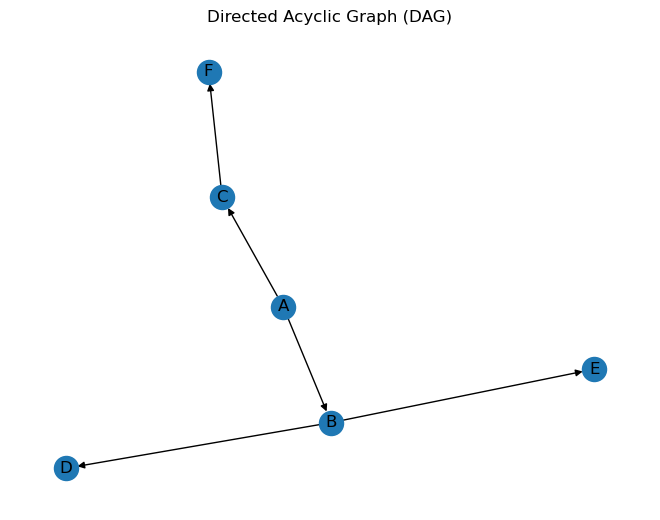

In [27]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Define the adjacency matrix
adjacency_matrix = np.array([
    [0, 1, 1, 0, 0, 0],  # Node 0 has edges to nodes 1 and 2
    [0, 0, 0, 1, 1, 0],  # Node 1 has edges to nodes 3 and 4
    [0, 0, 0, 0, 0, 1],  # Node 2 has an edge to node 5
    [0, 0, 0, 0, 0, 0],  # Node 3 has no outgoing edges
    [0, 0, 0, 0, 0, 0],  # Node 4 has no outgoing edges
    [0, 0, 0, 0, 0, 0]   # Node 5 has no outgoing edges
])

# Create a directed graph from the adjacency matrix
G = nx.DiGraph(adjacency_matrix)

# Set a random seed for reproducibility
np.random.seed(42)

# Draw the graph
pos = nx.spring_layout(G)  # Position nodes using the spring layout algorithm

# Modify node positions (if desired)
# For example, move node 0 to position (0, 0)
pos[0] = (0, 0)

# Modify node labels (if desired)
node_labels = {0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F"}

# Draw the graph with modified positions and labels
nx.draw(G, pos, with_labels=True, labels=node_labels, arrows=True)
plt.title("Directed Acyclic Graph (DAG)")
plt.show()
